In [1]:
from splinter import Browser
from splinter.exceptions import ElementDoesNotExist
from bs4 import BeautifulSoup as bs

import pandas as pd
import os

import matplotlib.pyplot as plt
import scipy.stats as stats

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

In [2]:
#initialize Splinter browser
executable_path = {'executable_path': 'chromedriver.exe'}
browser = Browser('chrome', **executable_path, headless=False)

# Box Office Mojo Top 1000 Lifetime Grosses URL
url = 'https://www.boxofficemojo.com/chart/top_lifetime_gross/'
browser.visit(url)

movie_grosses = []

# Box Office Mojo only has the top 1000 highest grossing movies, divided into chunks of 200. If I didn't
# know ahead of time how many items to expect, I would use a while loop instead.
for x in range(5):
    
    # Create HTML object and parse with Beautiful Soup
    html = browser.html
    soup = bs(html, 'html.parser')
    
    # Retrieve all titles and grosses
    titles = soup.find_all('td', class_='a-text-left mojo-field-type-title')
    grosses = soup.find_all('td', class_='a-text-right mojo-field-type-money')
    years = soup.find_all('td', class_='a-text-left mojo-field-type-year')
    
    # relevant information is sotred as a list of lists
    for i in range(len(titles)):
        movie_grosses.append([titles[i].text, grosses[i].text, years[i].text])
    
    try:
        # Click the 'Next' button on each page
        browser.click_link_by_partial_text("Next page")
    except ElementDoesNotExist:
        print("Scraping Complete")

C:\Users\epayn\Anaconda3\lib\site-packages\splinter\driver\webdriver\__init__.py:528: FutureWarning: browser.find_link_by_partial_text is deprecated. Use browser.links.find_by_partial_text instead.
  FutureWarning,


Scraping Complete


In [3]:
# insert scraped data into dataframe
movie_grosses_df = pd.DataFrame(movie_grosses, columns = ["Title", "Gross", "Year"])

In [4]:
# adding additional column where the gross revenue is stored as an integer instead of a string
# remove first character ($) and commas
movie_grosses_df["grossint"] = movie_grosses_df["Gross"].apply(lambda x: int(x[1:].replace(",","")))

In [5]:
db_user = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = 5432

# This database must already exist
db_name = "IMDB_db"

engine = create_engine(f"postgres://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

In [7]:
# adding to postgres
movie_grosses_df.to_sql("movie_grosses", engine)

In [ ]:
# data found here: https://www.kaggle.com/ashirwadsangwan/imdb-dataset
# orignally in .tsv format, I changed to .csv and used pandas read_csv with tab seperators
titlebasics_df = pd.read_csv(os.path.join("..","data","titlebasics.csv"),sep='\t')
titleratings_df = pd.read_csv(os.path.join("..","data","titleratings.csv"),sep='\t')

In [ ]:
# this is a very large file, over 500mb. I loaded into postgres before doing any other transformations or
# analysis, and although that took about 20 min, afterwards it's quick to read from the database
titlebasics_df.to_sql("title_basics", engine)

In [ ]:
# Does not include the latest Star Wars or Jumanji movies, so they w
titleratings_df.to_sql("title_ratings", engine)

In [76]:
# query designed in postgres. I tried using session queries to do this, but I had trouble with distinct
mgr = pd.read_sql('SELECT DISTINCT ON (mg."grossint") tr."tconst", mg.*, tr."averageRating", tr."numVotes" FROM "movie_grosses" mg LEFT JOIN "title_basics" tb ON ((tb."originalTitle" = mg."Title" OR tb."primaryTitle" = mg."Title") AND (tb."startYear" = mg."Year" OR (tb."startYear"::int8)+1 = mg."Year"::int8 OR (tb."startYear"::int8)+2 = mg."Year"::int8 )) INNER JOIN "title_ratings" tr ON tr."tconst" = tb."tconst" WHERE tb."titleType" = \'movie\' ORDER BY mg."grossint" DESC;', engine)
mgr.drop("index", axis=1, inplace=True)

In [70]:
# this is only to get information on two missing records: Once Upon a Time ...in Hollywood, and Everest
stragglers = pd.read_sql('SELECT DISTINCT ON (tr."numVotes") tb."originalTitle", tr."tconst", tr."averageRating", tr."numVotes" FROM "title_basics" tb INNER JOIN "title_ratings" tr ON tr."tconst" = tb."tconst" WHERE tb."titleType" = \'movie\' AND (tb."originalTitle" in (\'Everest\', \'Once Upon a Time... in Hollywood\') OR tb."primaryTitle" in (\'Everest\', \'Once Upon a Time ...in Hollywood\')) ORDER BY tr."numVotes" DESC;', engine)
OUATIH = movie_grosses_df.loc[movie_grosses_df["Title"]=="Once Upon a Time ...in Hollywood",:]
Everest =  movie_grosses_df.loc[movie_grosses_df["Title"]=="Everest",:]

In [89]:
# one-by-one insertion is never ideal, but these two movies had slight inconsistencies in their data, 
# making it difficult to capture them in the regular query
mgr.loc[len(mgr)] = [stragglers.iloc[0, 1],stragglers.iloc[0, 0], OUATIH.iloc[0,1], OUATIH.iloc[0,2],
            OUATIH.iloc[0,3], stragglers.iloc[0, 2], stragglers.iloc[0, 3]]
mgr.loc[len(mgr)] = [stragglers.iloc[1, 1],stragglers.iloc[1, 0], Everest.iloc[0,1], Everest.iloc[0,2],
            Everest.iloc[0,3], stragglers.iloc[1, 2], stragglers.iloc[1, 3]]

In [90]:
mgr.tail()

,tconst,Title,Gross,Year,grossint,averageRating,numVotes
993,tt1077368,Dark Shadows,"$79,727,149",2012,79727149,6.2,234904
994,tt0071455,Earthquake,"$79,666,653",1974,79666653,5.9,12832
995,tt1114677,Hannah Montana: The Movie,"$79,576,189",2009,79576189,4.4,37572
996,tt7131622,Once Upon a Time... in Hollywood,"$141,103,164",2019,141103164,8.0,228765
997,tt2719848,Everest,"$87,178,599",1998,87178599,7.1,184813


C:\Users\epayn\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(4, 30000000, 'Slope = 30465520.0, Intercept = -45985340.0, R = 0.291')

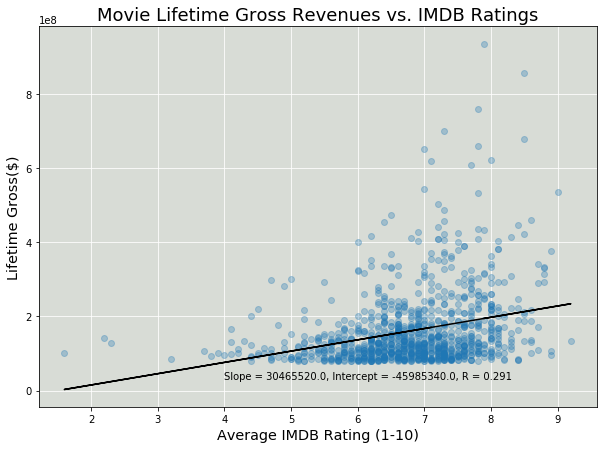

In [91]:
# plotting and linear regression
rating_gross_regression = stats.linregress(mgr["averageRating"], mgr["grossint"])

plt.figure(figsize=(10,7))
plt.title("Movie Lifetime Gross Revenues vs. IMDB Ratings", fontsize=18)
axes = plt.axes()

axes.set_facecolor("xkcd:light grey")
axes.set_axisbelow(True)
axes.grid(axis="both", color = "w")

axes.set_xlabel("Average IMDB Rating (1-10)",size="x-large")
axes.set_ylabel("Lifetime Gross($)",size="x-large")

plt.scatter(mgr["averageRating"], mgr["grossint"], alpha = .3)
plt.plot(mgr["averageRating"], mgr["averageRating"]*rating_gross_regression[0]+rating_gross_regression[1],
        c="black")
plt.annotate(f"Slope = {round(rating_gross_regression[0],-1)}," + \
             f" Intercept = {round(rating_gross_regression[1],-1)}, R = {round(rating_gross_regression[2],3)}", 
             (4, 30000000))